# <center>Government Technology Maturity on Economic Wealth, Technological</center>
# <center>Infrastructure and Regional Differences</center>

## Abstract
This study examines the factors correlating to **Government Technology Maturity Index (GTMI)** across 112 countries. Utilizing regression models, I explore how economic wealth, education investment, human capital, labor force dependency, technological infrastructure and regional factors contribute to the maturity of government technology. The findings indicate a significant correlation between the economic wealth of a country and the government technology maturity, along with human capital and technological foundation quality.

In [1]:
import pandas as pd
import numpy as np
import json
import requests

from stargazer.stargazer import Stargazer
import statsmodels.api as sm
import statsmodels.formula.api as smf

import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_white'

In [2]:
def parse_API_result(indicator_name: str, indicator: str):
    params = {
        'format': 'json',
        'per_page': '10000',
    }
    
    if '2020' in indicator_name:
        params['date'] = '2020'
    elif '2019' in indicator_name:
        params['date'] = '2019'
    else:
        params['date'] = '2021'
    
    url = f"http://api.worldbank.org/v2/country/all/indicator/{indicator}"
    print(f"Calling get API: [{url}]")
    
    response = None

    try:
        response = requests.get(url, params=params, headers={"User-Agent": "curl/7.68.0"})
    except requests.exceptions.RequestException as e:
        print(f"""There is s an error calling the url {url}
                    Error message: {e}""")

    if response is not None and response.status_code == 200:
        response_json = json.loads(response.text)
        return response_json
    else:
        print(f"""There is an error calling the url {url}
                    No response received.""")
        return None

In [3]:
api_indicator = {
    'GDP_per_capita': 'NY.GDP.PCAP.CD',
    'gov_expense_education_percent_GDP': 'SE.XPD.TOTL.GD.ZS',
    'gov_expense_percent_GDP': 'NE.CON.GOVT.ZS',
    'HCI_2020': 'HD.HCI.OVRL',
    'age_dependency_ratio': 'SP.POP.DPND',
    'working_age_pop_percent': 'SP.POP.1564.TO.ZS',
    'urban_pop': 'SP.URB.TOTL',
    'access_to_electricity_percent_pop_2021': 'EG.ELC.ACCS.ZS',
    'scientific_publishes_2020': 'IP.JRN.ARTC.SC',
    'SPI_score_2019': 'IQ.SPI.OVRL'
}
col_name_dict = {'ln_GDP_per_capita': 'ln(GDP/Pop)',
                  'HCI_percent': 'HCI',
                  'age_dependency_ratio_value': 'AgeDep',
                  'ln_urban_pop': 'ln(UrbanPop)',
                  'access_to_electricity_percent_pop_2021_value': 'ElectricityAccess',
                  'SPI_score_2019_value': 'SPI',
                  'ln_sci_publishes': 'ln(SciencePub)'}

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/viethngn/CEU_MSc_BA_ECBS5142_Data_Analysis_2/main/final_term_project/WBG_GovTech_Data_2023.tsv', sep='\t')
df.rename(columns={'Year': 'year',
                   'Code': 'countryiso3code',
                   'Economy': 'country',
                   'Grp': 'group'},
          inplace=True)
continent_df = pd.read_csv('https://raw.githubusercontent.com/viethngn/CEU_MSc_BA_ECBS5142_Data_Analysis_2/main/final_term_project/countryiso3code_continent.tsv', sep='\t')
continent_df.rename(columns={'ISO (3)': 'countryiso3code',
                             'Continent': 'continent',
                             'Region': 'region'}, inplace=True)
df = pd.merge(df, continent_df[['countryiso3code', 'continent', 'region']], on='countryiso3code', how='left')
del continent_df
df.head();

In [5]:
for k,v in api_indicator.items():
    tmp_df = pd.json_normalize(parse_API_result(k, v)[1])
    tmp_df = tmp_df[(tmp_df.countryiso3code != '')]
    tmp_df.rename(columns={'value': f"{k}_value",
                           'indicator.id': f"{k}_indicator_id",
                           'indicator.value': f"{k}_indicator_value"}, 
                  inplace=True)
    # df = pd.merge(df, tmp_df[["countryiso3code", f"{k}_indicator_id", f"{k}_indicator_value", f"{k}_value"]], on='countryiso3code', how='left')
    df = pd.merge(df, tmp_df[["countryiso3code", f"{k}_value"]], on='countryiso3code', how='left')
    del tmp_df
df.shape;

Calling get API: [http://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/SE.XPD.TOTL.GD.ZS]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/NE.CON.GOVT.ZS]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/HD.HCI.OVRL]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/SP.POP.DPND]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/SP.POP.1564.TO.ZS]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/SP.URB.TOTL]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/EG.ELC.ACCS.ZS]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/IP.JRN.ARTC.SC]
Calling get API: [http://api.worldbank.org/v2/country/all/indicator/IQ.SPI.OVRL]


## 1. Introduction
The government has always been the backbone of any country, especially in the modern world where everything changes fast as technology progresses. Understanding the factors that can drive government technology to overcome the rising challenges of efficiency, transparency and public engagement is crucial for any country. The Government Technology Maturity Index (GTMI) is one of the pivotal benchmark to assess how governments incorporate technology into their operations and services to meet the public expectations.

This paper aims to:
- Identify the key indicator of GMTI across different countries
- Analyze the correlation between GMTI, economic wealth and education spending
- Analyze the correlation between GMTI, economic wealth, human capital and population dependency on labor force
- Analyze the correlation between GMTI, economic wealth and technological infrastructure
- Analyze any correlation between GMTI and regional disparities

Based on intuition and preliminary observation of the data, the following are the expectations of the relationship between GTMI and the dependent variables to be verified with this study:
- Wealthier countries with higher GDP per capita have higher GTMI
- Countries investing more into education have better GTMI
- Countries with higher human capital and lower population dependency on the labor force obtain higher GTMI
- Countries with better technological infrastructure and research have higher GTMI
- Regional factors have significant influence on a country's GTMI

## 2. Data
The data used in this paper comes from the World Bank Data Catalog, mainly from the GovTech Dataset and the World Development Indicators dataset. The two datasets are merged together and enhanced with the World Bank country ISO 3 code metadata to obtain the appropriate country continents and regions. Originally, the merged data contains 198 observations, where each observation is one country. However, due to missing data from the World Development Indicators dataset across different features and countries, the filtered data consists of 112 observations.

For this study, the primary dependent variable is GTMI, representing government technology maturity. However, since the GTMI values range from 0 to 1, I will instead transform it into GTMIx100, which is 100 times the original GTMI value for better clarity. Inherently, each unit increase in GTMIx100 will be understood as a hundredth increase in GTMI. Meanwhile, the exploratory variable is the natural log of GDP per capita, while other control variables are divided into 4 main groups: Educational and spending indicators, Human capital indicators, Technological advance indicators and Regional indicators.  All independent variables are listed and explained below with their appropriate transformation:
- Exploratory variable:
    - Natural log of GDP per capita
- Educational indicators:
    - Government expense on education (percentage of GDP)
    - Government overall expense (percentage of GDP)
- Human capital indicators:
    - Human capital index HCI (percentage)
    - Age dependency ratio (percentage of population under 15 and over 64 dependent on the working age)
    - Natural log of urban population
- Technological advance indicators:
    - Population with access to electricity (percentage of total population)
    - Statistical performance indicator SPI (measurement of a country's data system performance)
    - Natural log of scientific publications
- Regional indicators:
    - Dummy variables by continents, with the America continent as the reference group

In [6]:
df = df[(df.GDP_per_capita_value.notna()) 
        & (df.gov_expense_education_percent_GDP_value.notna()) 
        & (df.gov_expense_percent_GDP_value.notna()) 
        & (df.HCI_2020_value.notna()) 
        & (df.SPI_score_2019_value.notna())]
df['GTMIx100'] = df.GTMI.apply(lambda x: x * 100)
df['HCI_percent'] = df.HCI_2020_value.apply(lambda x: x * 100)
df['ln_urban_pop'] = np.log(df.urban_pop_value)
df['ln_sci_publishes'] = np.log(df.scientific_publishes_2020_value)
df['ln_GDP_per_capita'] = np.log(df.GDP_per_capita_value)
df['is_Europe'] = df.continent.apply(lambda x: 1 if x == 'Europe' else 0)
df['is_Asia'] = df.continent.apply(lambda x: 1 if x == 'Asia' else 0)
df['is_Africa'] = df.continent.apply(lambda x: 1 if x == 'Africa' else 0)
df['is_Oceania'] = df.continent.apply(lambda x: 1 if x == 'Oceania' else 0)
df['ln_GDP_per_capita_sq'] = np.power(df.ln_GDP_per_capita, 2)
# America continent is the reference group

# store the data to file:
df.to_csv('gov_tech_maturity_raw_data_clean.tsv', sep='\t')
df.isna().sum();

In [7]:
# Selecting key variables for the descriptive statistics table
key_variables = ['GTMIx100', 'ln_GDP_per_capita', 'HCI_percent', 'age_dependency_ratio_value', 'ln_urban_pop', 'access_to_electricity_percent_pop_2021_value', 'SPI_score_2019_value', 'ln_sci_publishes']

# Calculating descriptive statistics for the selected variables
descriptive_stats = df[key_variables].describe()
descriptive_stats.rename(columns=col_name_dict, inplace=True)

# The describe method automatically calculates mean, std, min, 25%, 50%, 75%, max
# To add median explicitly and to format the table better, we can do the following adjustments
descriptive_stats.loc['median'] = df[key_variables].median()
descriptive_stats = descriptive_stats.loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
descriptive_stats = descriptive_stats.round(decimals=2)

descriptive_stats

,GTMIx100,ln(GDP/Pop),HCI,AgeDep,ln(UrbanPop),ElectricityAccess,SPI,ln(SciencePub)
mean,64.08,8.82,57.83,60.37,15.65,85.86,67.74,7.20
std,22.89,1.52,14.83,14.83,1.72,24.64,16.43,2.67
min,7.00,5.40,29.98,31.35,10.40,10.23,20.86,0.46
25%,48.95,7.60,44.65,51.48,14.67,85.44,54.94,5.11
50%,73.90,8.69,58.92,55.86,15.66,100.00,69.61,7.30
75%,81.47,10.13,70.94,67.38,16.92,100.00,82.60,9.44
max,95.60,11.80,87.91,105.44,20.60,100.00,90.09,13.41


## 3. Models
For this study, I construct multiple models, each tries to validate the finding expectations made in the introduction. Each model has GTMIx100 as the dependent variable, natural log of GDP per capita as the exploratory variables along with the appropriate control variables. The models are simple linear regressions with HC1 covariance type to ensure robustness to heteroscedasticity.

#### Model 1 - GMTI on rate of change in GDP per caipta
$GTMI\times100 = \beta_0 + \beta_1\times \ln(GDP/Pop)$

Model 1 is a simple linear regression of GMTIx100 on the natural log of GDP per capita. From the model, I obtain $\beta_1$ with the value of 8.86 and the R-squared of 0.34. This suggests for 1% increased in the GDP per capita, the GTMIx100 increases by 8.86 on average, equivalent to a 0.0886 increase in the original GTMI score. The $\beta_1$ is significant 1%, which strongly indicates the same pattern can be observed across countries.

However, when I first check the Loess regression between GTMIx100 and log of GDP per capita, the Loess line suggests a non-linear relationship. When the log of GDP per capita is at 10 onward (equivalent to countries having GDP per capita from ~USD20,000 onward), the regression line is almost flat. In order to examine this relationship more closely, I construct model 1.1 (**fill in fig**), which includes a squared term for log of GDP per capita:

$GTMI\times100 = \beta_0 + \beta_1\times \ln(GDP/Pop) + \beta_2\times \ln(GDP/Pop)^2$

In model 1.1, $\beta_2$ is -1.32 and is significant at 10%. This suggests that initially, as GDP per capita increases, GTMIx100 increases at a faster rate, but when GDP per capita is beyond ~USD20,000, the rate of increase in GTMIx100 starts to diminish. The R-squared of model 1.1 is 0.35, higher than model 1 R-squared of 0.34, proves to be a slightly better fit. Hence, the diminishing returns behavior where wealthier countries with high GTMI benefit less from additional increase in wealth is likely to happen in the world.

In [8]:
reg1 = smf.ols(formula="GTMIx100 ~ ln_GDP_per_capita", data=df).fit(cov_type="HC1")
reg1_1 = smf.ols(formula="GTMIx100 ~ ln_GDP_per_capita + ln_GDP_per_capita_sq", data=df).fit(cov_type="HC1")

#### Model 2 - GMTI on government education expense
$GTMIx100 = \beta_0 + \beta_1\times \ln(GDP/Pop) + \beta_2\times EducationExp + \beta_3\times OverallExp$

This model tries to explain if the government education expense and overall expense have additional impact on the country GTMI. In this model, the $\beta_1$ is 9.83, while $\beta_2$ and $\beta_3$ are -0.5 and -0.61 respectively. Only $\beta_1$ is statistically significant, while $\beta_2$ and $\beta_3$ are not. Contrary to my initial expectation that countries investing more into education have better GTMI, this model suggests I may not have enough data or there is no relationship between the GTMI and the government spending across countries. However, GDP per capita remains to be the significant factor correlated to a country's GTMI as this model R-squared value of 0.4 is higher than model 1's R-squared.

In [9]:
reg2 = smf.ols(formula="GTMIx100 ~ ln_GDP_per_capita + gov_expense_education_percent_GDP_value + gov_expense_percent_GDP_value", data=df).fit(cov_type="HC1")

#### Model 3 - GMTI on human capital
$GTMI\times100 = \beta_0 + \beta_1\times \ln(GDP/Pop) + \beta_2\times HCI + \beta_3\times AgeDep + \beta_4\times \ln(UrbanPop)$

Model 3 examines the correlation between GMTIx100, log of GDP per capita and a country's human capital. In model 3, $\beta_1$ is -0.75, $\beta_2$ is 0.84, $\beta_3$ is -0.35 and $\beta_4$ is 3.62. Almost all coefficients are significant at 1%, except for $\beta_1$.  This means while GMTIx100 has a negative correlation with economic wealth, it is marginal in value and is not statistically significant. Rather, in this model, the variance in GMTIx100 is better explained by the other three independent variables in the model. From model 3, if all other variables are kept the same:
- GMTIx100 *increases* by 0.84 on average (equivalent to a 0.0084 *increase* in the GMTI) when the country's HCI increases by 1%
- GMTIx100 *decreases* by 0.35 on average (equivalent to a 0.0035 *decrease* in the GMTI) when the age dependencies increases by 1%
- GMTIx100 *increases* by 3.62 on average (equivalent to a 0.0362 *increase*** in the GMTI) when the urban population in the country increases by 1%

The model has an R-squared of 0.52, higher than both of the previous models, suggesting that it is a better fit. Overall, while the human capital and urbanization have a positive influence on government technology maturity, having a small labor force or aging population negatively impact the maturity of government technology.

In [10]:
reg3 = smf.ols(formula="GTMIx100 ~ ln_GDP_per_capita + HCI_percent + age_dependency_ratio_value + ln_urban_pop", data=df).fit(cov_type="HC1")

#### Model 4 - GMTI on technological advance
$GTMIx100 = \beta_0 + \beta_1\times \ln(GDP/Pop) + \beta_2\times ElectricityAccess + \beta_3\times SPI + \beta_4\times ln(SciencePub)$

This model tackles the hypothesis that countries with better technological infrastructure and research have higher GTMI. The coefficients of model 4 are: $\beta_1$ is -2.04, $\beta_2$ is 0.19, $\beta_3$ is 0.83 and $\beta_4$ is 1.83. Again, all coefficients are significant at 5% and 5% except $\beta_1$. This suggests that the other three independent variables are better at explaining the variance in the GMTIx100:
- GMTIx100 *increases* by 0.19 on average (equivalent to a 0.0019 *increase* in the GMTI) when 1% more of the population have access to electricity
- GMTIx100 *increases* by 0.83 on average (equivalent to a 0.0083 *decrease* in the GMTI) when the country's statistical performance improves by 1%
- GMTIx100 *increases* by 1.83 on average (equivalent to a 0.0183 *increase*** in the GMTI) when there is 1% more scientific publications

The R-squared of model 4 of 0.63 is the highest fitness score among the 5 main models, meaning a country's technological infrastructure has the strongest influence on government technology maturity compared to other groups of indicators in this paper.

On the other hand, it is worth noting that the coefficient of log of GDP per capita in model 4 becomes negatively large. However, it is still not statistically significant here. Given that $\beta_1$ is mostly always significantly positive in previous models, this change in sign might suggest that there is some complexity in the correlation between GDP per capita and the other independent variables in this model. To examine it more carefully, I construct model 4.1 to include an interaction term for log of GDP per capita and the SPI:

$GTMI\times100 = \beta_0 + \beta_1\times \ln(GDP/Pop) + \beta_2\times ElectricityAccess + \beta_3\times SPI + \beta_4\times ln(SciencePub) + \beta_5\times \ln(GDP/Pop)\times SPI$

Model 4.1 reveals that $\beta_5$ has a value of -0.28 with the significant level of 1%, meaning when a country data system quality improves, the effect of economical wealth on government technology maturity diminishes. In this model, $\beta_1$ is positive again with significant level of 1% revealing that GDP per capita is still a key factor in the GTMI correlation. However, as the other control variables in the technological advance indicators group better explain the variance in GTMI and the negative correlation with the control variables, the log of GDP per capita in model 4 (and also possibly in model 3) appears less significant.

In [18]:
reg4 = smf.ols(formula="GTMIx100 ~ ln_GDP_per_capita + access_to_electricity_percent_pop_2021_value + SPI_score_2019_value + ln_sci_publishes", data=df).fit(cov_type="HC1")
reg4_1 = smf.ols(formula="GTMIx100 ~ ln_GDP_per_capita + access_to_electricity_percent_pop_2021_value + SPI_score_2019_value + ln_sci_publishes + ln_GDP_per_capita * SPI_score_2019_value", data=df).fit(cov_type="HC1")

#### Model 5 - GMTI on regional factors
$GTMIx100 = \beta_0 + \beta_1\times \ln(GDP/Pop) + \beta_2\times isEurope + \beta_3\times isAsia + \beta_4\times isAfrica + \beta_5\times isOceania$

This model tries to explain if there is regional factors have additional impact on the government technology maturity. I use dummy variables for different continents, with the America continent as the reference group. In this model, $\beta_1$ is 6.38, while $\beta_2$ to $\beta_5$ are 4.23, 7.36, -10.21 and -19.5 respectively. $\beta_2$ an $\beta_3$ suggest that European and Asian countries on average have higher government technology maturity, while $\beta_4$ and $\beta_5$ suggest that African and Oceanian countries on average has much lower maturity in government technology. However, only $\beta_1$ is statistically significant, while $\beta_2$ to $\beta_5$ are not. This means the data in this paper cannot guarantee that such regional differences exist across all countries. GDP per capita, on the other hand, remains to be the significant factor correlated to a government technology maturity as this model R-squared value of 0.42 is higher than model 1's R-squared.

In [12]:
reg5 = smf.ols(formula="GTMIx100 ~ ln_GDP_per_capita + is_Europe + is_Asia + is_Africa + is_Oceania", data=df).fit(cov_type="HC1")
# America is the reference group

In [13]:
stargazer = Stargazer([reg1, reg1_1, reg2, reg3, reg4, reg4_1, reg5])
stargazer.show_model_numbers(True)
# stargazer.cov_spacing = 1.5
stargazer.covariate_order(
    [
        'Intercept',
        'ln_GDP_per_capita',
        'ln_GDP_per_capita_sq',
        'ln_GDP_per_capita:SPI_score_2019_value',
        'gov_expense_education_percent_GDP_value',
        'gov_expense_percent_GDP_value',
        'HCI_percent',
        'age_dependency_ratio_value',
        'ln_urban_pop',
        'access_to_electricity_percent_pop_2021_value',
        'SPI_score_2019_value',
        'ln_sci_publishes',
        'is_Europe',
        'is_Asia',
        'is_Africa',
        'is_Oceania'
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "ln_GDP_per_capita": "ln GDP per capita"
    }
)
stargazer

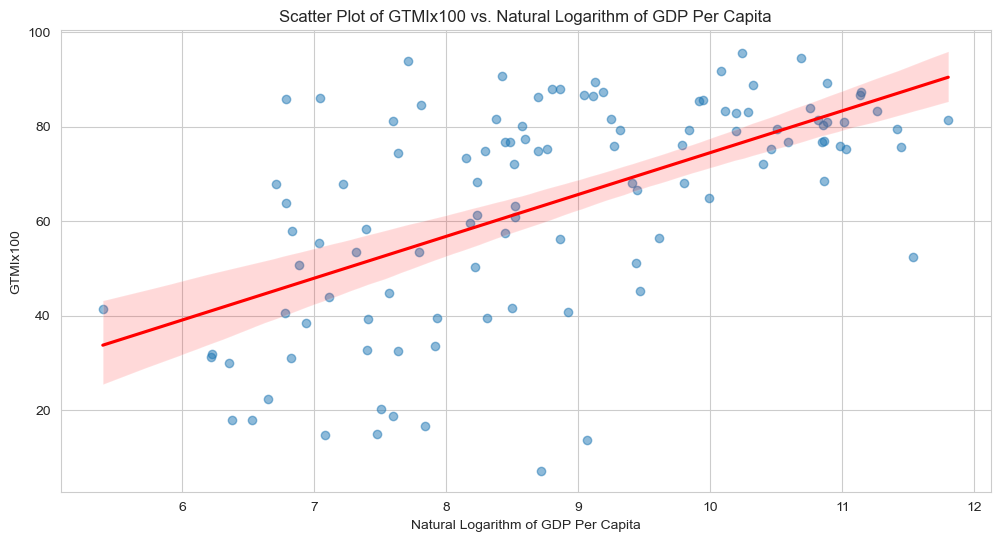

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for the scatter plot
x = df['ln_GDP_per_capita']
y = df['GTMIx100']

# Creating the scatter plot with regression line
plt.figure(figsize=(12, 6))
sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Adding titles and labels
plt.title('Scatter Plot of GTMIx100 vs. Natural Logarithm of GDP Per Capita')
plt.xlabel('Natural Logarithm of GDP Per Capita')
plt.ylabel('GTMIx100')

# Show the plot
plt.show()

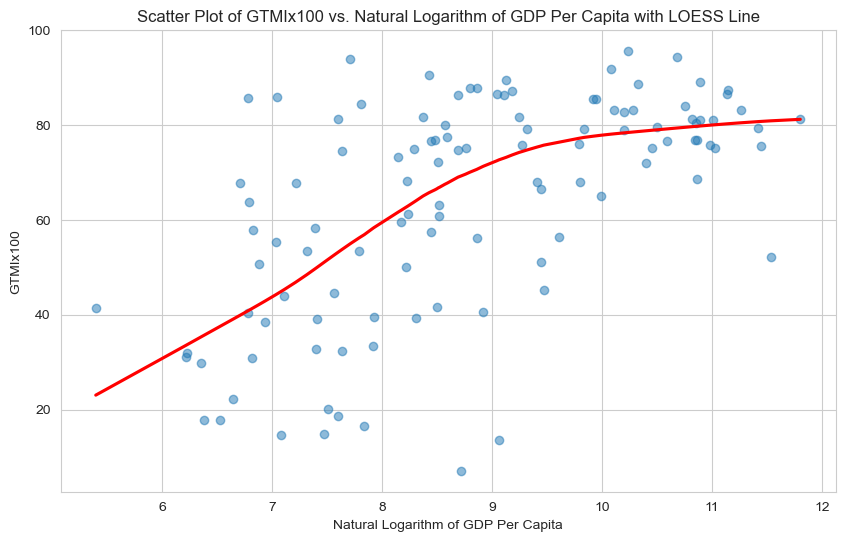

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data for the plot
x = df['ln_GDP_per_capita']
y = df['GTMIx100']

# Creating a scatter plot with a LOESS line using Seaborn
plt.figure(figsize=(10, 6))
sns.regplot(x=x, y=y, lowess=True, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Adding titles and labels
plt.title('Scatter Plot of GTMIx100 vs. Natural Logarithm of GDP Per Capita with LOESS Line')
plt.xlabel('Natural Logarithm of GDP Per Capita')
plt.ylabel('GTMIx100')

# Show the plot
plt.show()

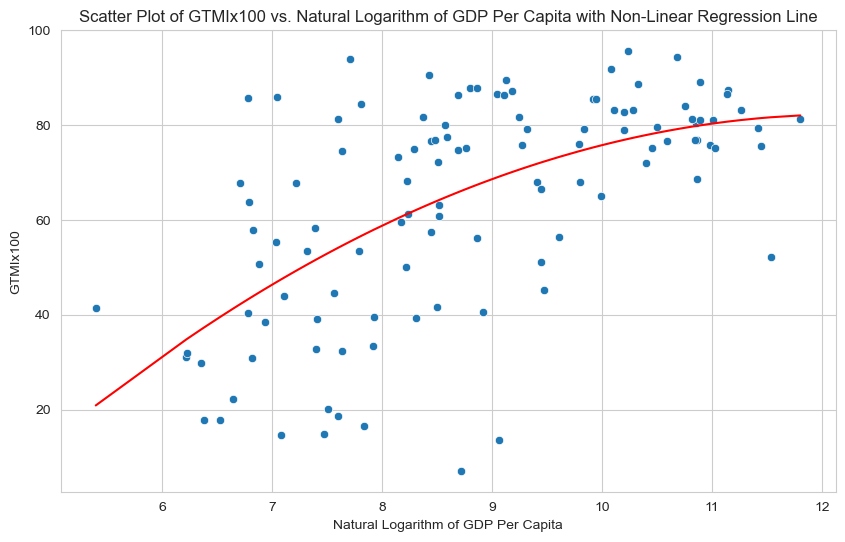

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
x = df['ln_GDP_per_capita']
y = df['GTMIx100']

# Creating a scatter plot with a non-linear regression line using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y)

# Sorting the x values and calculating the corresponding predicted y values
x_sorted = np.sort(x)
predicted_y = reg1_1.params['Intercept'] + reg1_1.params['ln_GDP_per_capita'] * x_sorted + reg1_1.params['ln_GDP_per_capita_sq'] * np.power(x_sorted, 2)

# Adding the non-linear regression line
plt.plot(x_sorted, predicted_y, color='red')

# Adding titles and labels
plt.title('Scatter Plot of GTMIx100 vs. Natural Logarithm of GDP Per Capita with Non-Linear Regression Line')
plt.xlabel('Natural Logarithm of GDP Per Capita')
plt.ylabel('GTMIx100')

# Show the plot
plt.show()

In [17]:
# Creating a DataFrame to compare the fit of different regression models
model_comparison = {
    'Model': ['Model 1', 'Model 1.1', 'Model 2', 'Model 3', 'Model 4', 'Model 4.1', 'Model 5'],
    'R-squared': [reg1.rsquared, reg1_1.rsquared, reg2.rsquared, reg3.rsquared, reg4.rsquared, reg4_1.rsquared, reg5.rsquared],
    'Adjusted R-squared': [reg1.rsquared_adj, reg1_1.rsquared_adj, reg2.rsquared_adj, reg3.rsquared_adj, reg4.rsquared_adj, reg4_1.rsquared_adj, reg5.rsquared_adj],
    'F-statistic': [reg1.fvalue, reg1_1.fvalue, reg2.fvalue, reg3.fvalue, reg4.fvalue, reg4_1.fvalue, reg5.fvalue]
}

comparison_df = pd.DataFrame(model_comparison)
comparison_df.set_index('Model', inplace=True)
comparison_df = comparison_df.round(2)

comparison_df

,R-squared,Adjusted R-squared,F-statistic
Model,,,
Model 1,0.34,0.34,75.49
Model 1.1,0.36,0.35,39.40
Model 2,0.41,0.40,27.13
Model 3,0.54,0.52,30.13
Model 4,0.64,0.63,68.24
Model 4.1,0.67,0.66,57.71
Model 5,0.44,0.42,17.09
